# Use with TFP models

BlackJAX can take any log-probability function as long as it is compatible with JAX's primitives. In this notebook we show how we can use tensorflow-probability as a modeling language and BlackJAX as an inference library.

``` {admonition} Before you start
You will need [tensorflow-probability](https://www.tensorflow.org/probability) to run this example. Please follow the installation instructions on TFP's repository.
```

We reproduce the Eight Schools example from the [TFP documentation](https://www.tensorflow.org/probability/examples/Eight_Schools).

Please refer to the [original TFP example](https://www.tensorflow.org/probability/examples/Eight_Schools) for a description of the problem and the model that is used.

In [1]:
import numpy as np


num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32
)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32
)  # treatment SE

In [2]:
import jax
import jax.numpy as jnp

from datetime import date
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

We implement the non-centered version of the hierarchical model:

In [3]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
jdc = tfd.JointDistributionCoroutineAutoBatched

@jdc
def model():
    mu = yield tfd.Normal(0.0, 10.0, name="avg_effect")
    log_tau = yield tfd.Normal(5.0, 1.0, name="avg_stddev")
    theta_prime = yield tfd.Sample(tfd.Normal(0, 1),
                                   num_schools,
                                   name="school_effects_standard")
    yhat = mu + jnp.exp(log_tau) * theta_prime
    yield tfd.Normal(yhat, treatment_stddevs, name="treatment_effects")

We need to translate the model into a log-probability density function that will be used by Blackjax to perform inference.

In [4]:
# Condition on the observed
pinned_model = model.experimental_pin(treatment_effects=treatment_effects)

logdensity_fn = pinned_model.unnormalized_log_prob

Let us first run the window adaptation to find a good value for the step size and for the inverse mass matrix. As in the original example we will run the HMC integrator 3 times at each step.

In [5]:
import blackjax


initial_position = {
    "avg_effect": jnp.zeros([]),
    "avg_stddev": jnp.zeros([]),
    "school_effects_standard": jnp.ones([num_schools]),
}


rng_key, warmup_key = jax.random.split(rng_key)
adapt = blackjax.window_adaptation(
    blackjax.hmc, logdensity_fn, num_integration_steps=3
)

(last_state, parameters), _ = adapt.run(warmup_key, initial_position, 1000)
kernel = blackjax.hmc(logdensity_fn, **parameters).step

We can now perform inference with the tuned kernel:

In [6]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, infos

In [7]:
rng_key, sample_key = jax.random.split(rng_key)
states, infos = inference_loop(sample_key, kernel, last_state, 50_000)

Extra information about the inference is contained in the `infos` namedtuple. Let us compute the average acceptance rate:

In [8]:
acceptance_rate = np.mean(infos.acceptance_rate)
print(f"Average acceptance rate: {acceptance_rate:.2f}")

Average acceptance rate: 0.89


The samples are contained as a dictionnary in `states.position`. Let us compute the posterior of the school treatment effect:

In [9]:
samples = states.position
school_effects_samples = (
    samples["avg_effect"][:, np.newaxis]
    + np.exp(samples["avg_stddev"])[:, np.newaxis] * samples["school_effects_standard"]
)

And now let us plot the correponding chains and distributions:

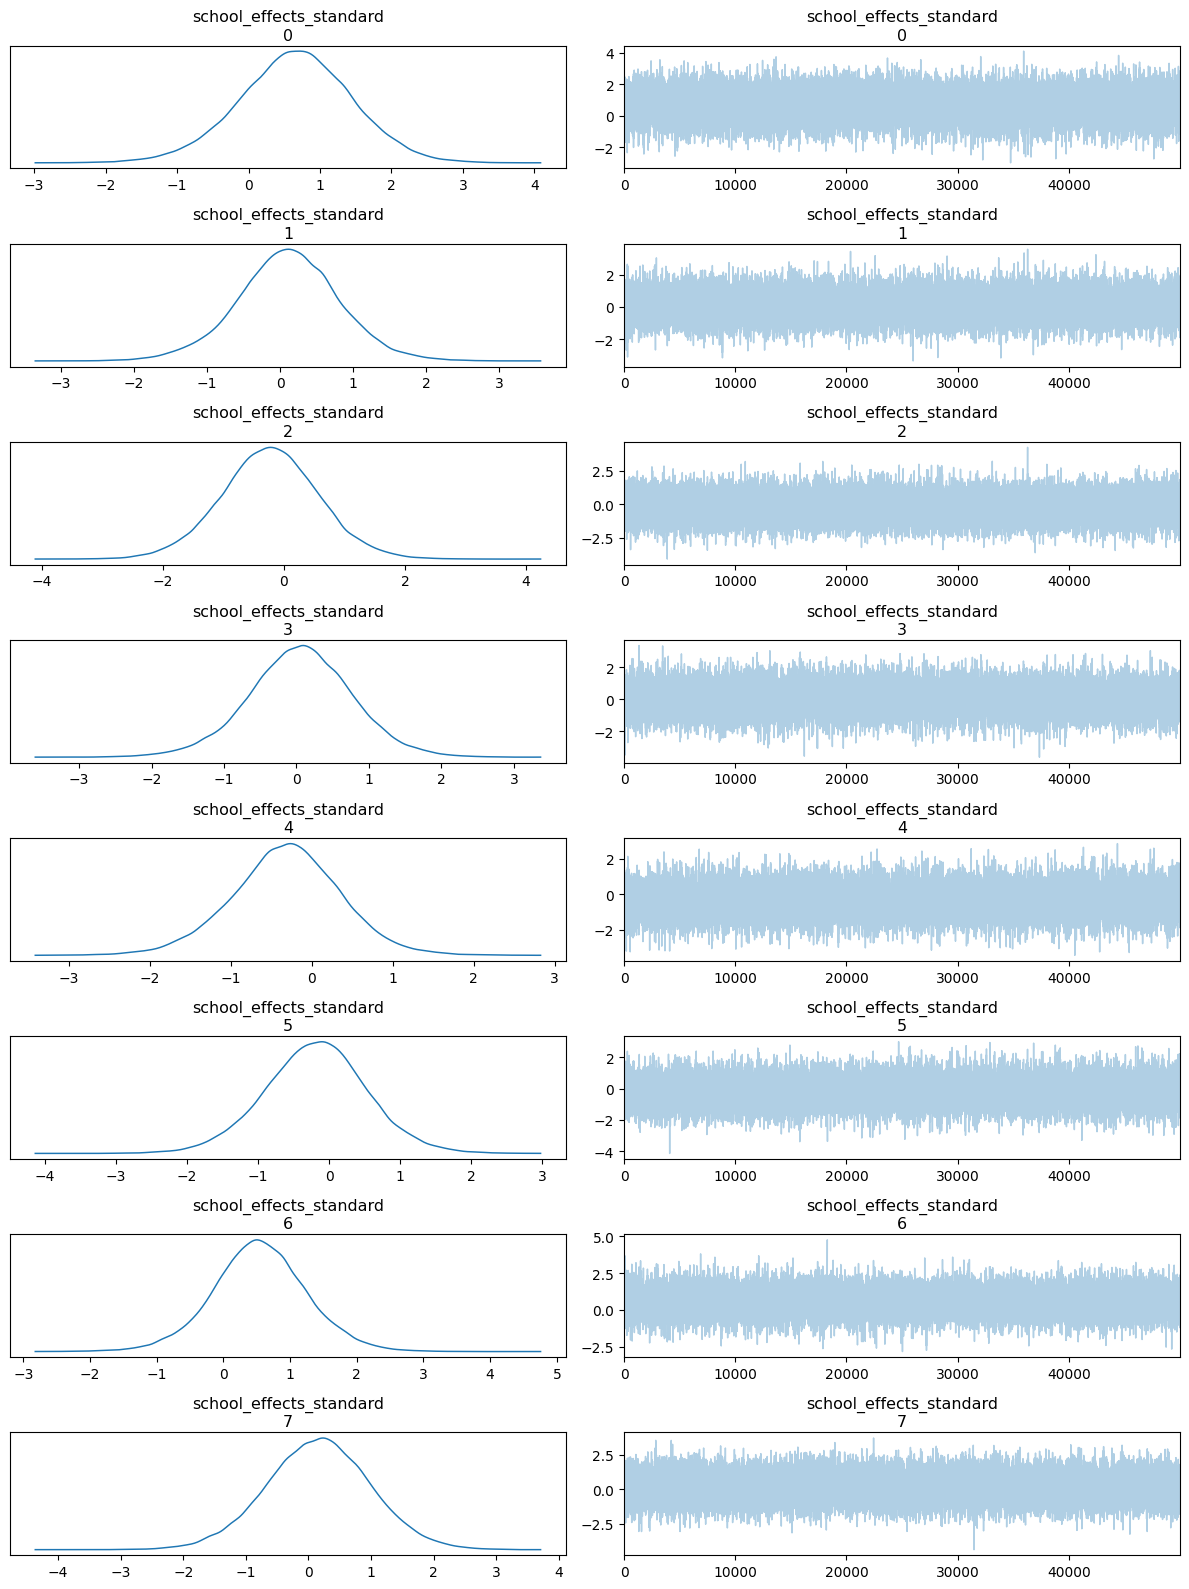

In [10]:
import matplotlib.pyplot as plt
import arviz as az

idata = az.from_dict(posterior={k: v[None, ...] for k, v in states.position.items()})
az.plot_trace(idata, var_names=["school_effects_standard"], compact=False)
plt.tight_layout();

In [11]:
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
avg_effect,5.701,5.457,-4.721,15.893,0.050,0.036,11961.0,14992.0,NaN
avg_stddev,2.445,0.514,1.457,3.393,0.005,0.004,10802.0,14501.0,NaN
school_effects_standard[0],0.656,0.796,-0.813,2.201,0.006,0.004,17456.0,24307.0,NaN
school_effects_standard[1],0.104,0.704,-1.287,1.401,0.005,0.004,18247.0,27259.0,NaN
school_effects_standard[2],-0.235,0.810,-1.810,1.267,0.006,0.004,20932.0,28968.0,NaN
school_effects_standard[3],0.054,0.727,-1.334,1.428,0.005,0.004,19259.0,27077.0,NaN
school_effects_standard[4],-0.324,0.683,-1.667,0.925,0.005,0.003,19478.0,27384.0,NaN
school_effects_standard[5],-0.187,0.728,-1.583,1.185,0.006,0.004,16569.0,25435.0,NaN
school_effects_standard[6],0.545,0.712,-0.826,1.895,0.005,0.004,18391.0,24827.0,NaN
school_effects_standard[7],0.151,0.834,-1.437,1.718,0.006,0.004,19068.0,29302.0,NaN


In [12]:
rng_key, warmup_key = jax.random.split(rng_key)
adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn
)

(last_state, parameters), all_info = adapt.run(warmup_key, initial_position, 1000)

In [13]:
nsteps, counts = np.unique(all_info.info.num_integration_steps[-500:], return_counts=True)
nsteps, counts
# plt.bar(nsteps, counts, align="center");

(array([ 1,  3,  7, 11, 12, 15, 23, 31, 63], dtype=int32),
 array([  3,  39, 358,   5,   1,  82,   1,  10,   1]))

In [14]:
%%time
rng_key, sample_key = jax.random.split(rng_key)
nuts_kernel = blackjax.nuts(logdensity_fn, **parameters).step
states, infos = inference_loop(sample_key, nuts_kernel, last_state, 1000)

CPU times: user 1.4 s, sys: 46.2 ms, total: 1.45 s
Wall time: 1.42 s


In [15]:
%%time
rng_key, sample_key = jax.random.split(rng_key)
hmc_kernel = blackjax.hmc(logdensity_fn, **parameters, num_integration_steps=7).step
states, infos = inference_loop(sample_key, hmc_kernel, last_state, 1000)

CPU times: user 501 ms, sys: 26.6 ms, total: 527 ms
Wall time: 516 ms


In [21]:
%%time
rng_key, num_step_key, sample_key = jax.random.split(rng_key, 3)

num_step_fn = lambda key: jax.random.choice(key, nsteps, p=counts)
kernal_factory = blackjax.mcmc.hmc.build_dynamic_kernel(
    integration_steps_fn=num_step_fn)

hmc_kernel = lambda key, state: kernal_factory(key, state, logdensity_fn, **parameters)
init_state = blackjax.mcmc.hmc.init_dynamic(last_state.position, logdensity_fn, num_step_key)
states, infos = inference_loop(sample_key, hmc_kernel, init_state, 1000)

CPU times: user 766 ms, sys: 71.3 ms, total: 838 ms
Wall time: 821 ms


In [17]:
np.unique(infos.num_integration_steps, return_counts=True)

(array([ 1,  3,  7, 11, 12, 15, 23, 31, 63], dtype=int32),
 array([  7,  81, 706,  11,   1, 175,   1,  17,   1]))

In [18]:
%%time
hmc_base = blackjax.hmc.build_kernel()
num_step_fn = lambda key: jax.random.choice(key, nsteps, p=counts)

def dynamic_hmc_kernel(rng_key, state):
    key0, key1 = jax.random.split(rng_key)
    num_integration_steps = num_step_fn(key0)
    return hmc_base(
        key1,
        state,
        logdensity_fn,
        **parameters,
        num_integration_steps=num_integration_steps,
    )

states, infos = inference_loop(sample_key, dynamic_hmc_kernel, last_state, 1000)

CPU times: user 734 ms, sys: 64.9 ms, total: 799 ms
Wall time: 783 ms


In [19]:
np.unique(infos.num_integration_steps, return_counts=True)

(array([ 1,  3,  7, 11, 15, 23, 31, 63], dtype=int32),
 array([  4,  91, 723,   9, 150,   1,  15,   7]))

In [20]:
def _halton_sequence(i, max_bits=10):
  bit_masks = 2**jnp.arange(max_bits, dtype=int)
  return jnp.einsum('i,i->', jnp.mod((i + 1) // bit_masks, 2),
                   0.5 / bit_masks)

# random_array = ...
# def _halton_sequence(i):
#   return random_array[i]

max_num_integration_steps = 200
integration_steps_fn = lambda step: (_halton_sequence(step) * max_num_integration_steps).astype(int)
next_random_arg_fn = lambda step: step+1

kernal_factory = blackjax.mcmc.hmc.build_dynamic_kernel(
  next_random_arg_fn=next_random_arg_fn, 
  integration_steps_fn=integration_steps_fn)

hmc_kernel = lambda key, state: kernal_factory(key, state, logdensity_fn, **parameters)
init_state = blackjax.mcmc.hmc.DynamicHMCState(
    position=last_state.position,
    logdensity=last_state.logdensity,
    logdensity_grad=last_state.logdensity_grad,
    random_generator_arg=0)
states, infos = inference_loop(sample_key, hmc_kernel, init_state, 1000)
np.unique(infos.num_integration_steps, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177